In [3]:
%matplotlib widget
import numpy as np
import json, os, glob
from matplotlib import pyplot as plt
from scipy.optimize import curve_fit
from textwrap import wrap

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XAS_functions import *
from alvra_tools.XAS_utils import *
from sfdata import SFScanInfo

import warnings
warnings.filterwarnings('ignore')

# Load data 

In [8]:
pgroup = 'p22591'
Loaddir_name = ''

runlist = [32]
#runlist = np.arange(205, 225)
t0_offsets = [0]*len(runlist)
#t0_offsets = [50, 20]

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_name)

In [9]:
#Plot_correlations_scan(pgroup, Loaddir, runlist, path='work/TestData', timescan=True, lowlim = 0.95)
#Plot_scan_2diodes(pgroup, Loaddir, runlist, path='work/TestData', timescan=True)

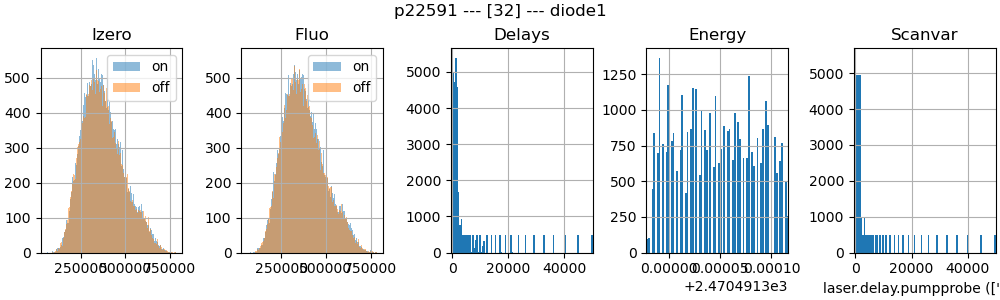

Time delay axis rebinned with TT data


In [10]:
withTT    = True

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
firstrun = glob.glob('/sf/alvra/data/{}/raw/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]
#firstrun = glob.glob('/sf/alvra/data/{}/work/TestData/*{:04d}*/meta/scan.json'.format(pgroup, runlist[0]))[0]

from sfdata import SFScanInfo
scan = SFScanInfo(firstrun)
#acqlist = np.arange(1, len(scan.files))

data1, titlestring_stack1 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=False, t0_offset=t0_offsets)
data2, titlestring_stack2 = load_reduced_data(pgroup, Loaddir, runlist, switch_diodes=True, t0_offset=t0_offsets)
Plot_reduced_data(data1, scan, titlestring_stack1, withTT)
#Plot_reduced_data(data2, scan, titlestring_stack2, withTT)

readbacks = np.asarray(data1['readbacks'], dtype=object)

## [Average scans](#Averaged-scans)
## [Overlay curves](#Overlay-data)

# Average scans

In [11]:
# print(data1['Delays_stage'])

Time delay axis rebinned with TT data
35891 shots out of 40013 survived (total shots: 40014)


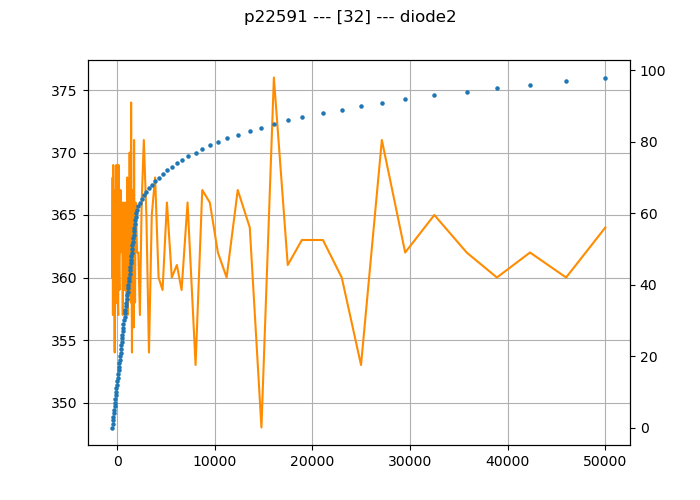

In [12]:
quantile = 0.95

binsize = 25
min_delay = -500
max_delay = 1000

n_points = len(readbacks[0])
(variable_bins, numbins)= (True, 100)
thresh=0
n_sigma=5
rawflag = True
####################################################################
####################################################################

#results1 = Rebin_and_filter_timescans(data1, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, rawflag, numbins, variable_bins)
results2 = Rebin_and_filter_timescans(data2, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma, rawflag, numbins, variable_bins)
plot_bins_population(results2, titlestring_stack2)

In [15]:
results2.keys()

dict_keys(['GS', 'ES', 'pp', 'err_GS', 'err_ES', 'err_pp', 'Delay', 'howmany'])

KeyError: 'gs'

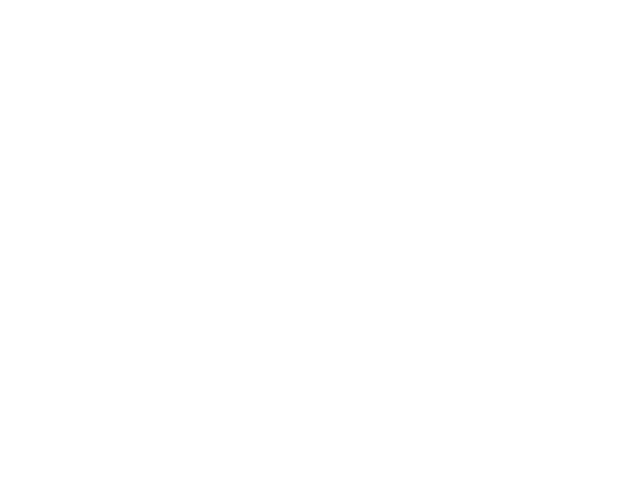

In [20]:
#pp_TT, Delay_fs_TT, pp_fit, indexNans = plot_kinetic_trace(results1, titlestring_stack1, binsize, withTT, fitflag=True) #errfunc_fwhm
# pp_TT, Delay_fs_TT, pp_fit, indexNans = plot_kinetic_trace(results2, titlestring_stack2, binsize, withTT, fitflag=False) #errfunc_fwhm
plt.figure()
plt.plot(results2['Delay'],results2['gs'])
plt.show()
Savedir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
#save_averaged_data(Savedir, runlist, results1, Delay_fs_TT, "diode1", indexNans)
save_averaged_data(Savedir, runlist, results2, Delay_fs_TT, "diode2", indexNans)

In [8]:
#results_ave, titlestring_ave = average_two_diodes(results1, results2, titlestring_stack1)
#pp_ave, Delay_fs_ave, pp_fit_ave, indexNans_ave = plot_kinetic_trace(results_ave, titlestring_ave, binsize, withTT, fitflag=True) #errfunc_fwhm
#save_averaged_data(Savedir, runlist, results_ave, Delay_fs_ave, "both_diodes", indexNans)

# Fit risetime

In [39]:
from lmfit.models import PseudoVoigtModel

pp_TT_derivative = gaussian_filter1d(pp_TT, 1, order = 1)

mod = PseudoVoigtModel()
pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
init = mod.eval(pars, x=Delay_fs_TT)
out = mod.fit(pp_TT_derivative, amplitude=1, center= 0, sigma=1, fraction=0.5, x=Delay_fs_TT)

pp_TT_derivative = gaussian_filter1d(pp_TT, 2, order = 1)
parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [500, 0, 20, 0])

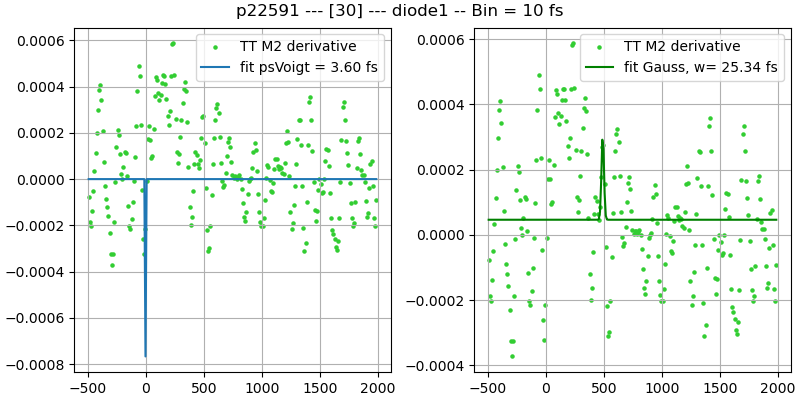

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
fig.suptitle(titlestring_stack1 + ' -- Bin = {} fs'.format(binsize))
ax1.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax1.plot(Delay_fs_TT, out.best_fit, '-', label = 'fit psVoigt = {:.2f} fs'.format(out.params.get('fwhm').value))#, w= {:.2f} fs'.format(np.abs(pars[2])))
ax1.grid()
ax1.legend(loc='upper right')

ax2.scatter(Delay_fs_TT, pp_TT_derivative, color='limegreen', label = 'TT M2 derivative', s = 5)
ax2.plot(Delay_fs_TT, gaussian(Delay_fs_TT,*parameters_M2), color='green',\
         label = 'fit Gauss, w= {:.2f} fs'.format(np.abs(parameters_M2[2]*2.355)))

ax2.legend(loc='upper right')
ax2.grid()
plt.show()

# FFT

100
240
(140,) (140,)


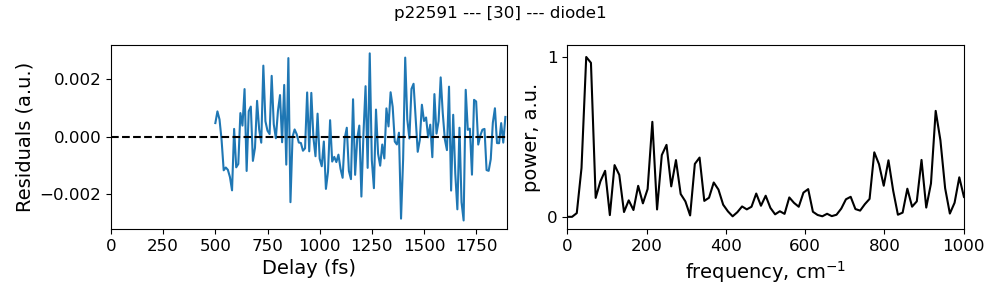

In [44]:
chosen_point_start = 500  #in fs
index_point_start = int(np.argwhere(Delay_fs_TT > chosen_point_start)[0])
print (index_point_start)

chosen_point_end = 1900 #in fs
index_point_end = int(np.argwhere(Delay_fs_TT > chosen_point_end)[0])
print (index_point_end)

transient = pp_TT[index_point_start:index_point_end]
x = Delay_fs_TT[index_point_start:index_point_end]

fit = pp_fit[index_point_start:index_point_end]

print(np.shape(transient), np.shape(x))
fitoutput = np.poly1d(np.polyfit(x, transient, 3))
pows = fitoutput(x)
transient2 = transient-pows
#transient2 = transient-fit
            
vals = np.hstack((transient2, np.zeros_like(transient2))) # pad
power = np.abs(np.fft.fft(vals))**2
frequencies = np.arange(0,0.999999999,1/len(vals))*16678*(2/binsize)

plt.figure(figsize=(10,3))
plt.suptitle(titlestring_stack1)
plt.subplot(121)

#plt.plot(np.arange(0, binsize*len(transient), binsize), transient)
plt.plot(chosen_point_start + np.arange(0, binsize*len(transient), binsize), transient2, '-')
plt.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Residuals (a.u.)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.xlim(0,chosen_point_end)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

plt.subplot(122)
plt.plot(frequencies,power/np.max(power), '-', color='black')
plt.xlim(0,chosen_point_end)
plt.xlabel('frequency, cm$^{-1}$', fontsize=14)
plt.ylabel('power, a.u.', fontsize=14)
plt.yticks([0,1])
plt.ylim(-0.075, 1.075)
plt.xlim(0,1000)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
#plt.vlines(1647, -0.1, 1.1, color='lightgrey', linestyle='dashed')
plt.tight_layout()

plt.show()
plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_fft.png', )

In [250]:
withTT    = False
switch_diodes = False

pgroup = 'p22588'
Loaddir_name = ''

runlist = [111]

jsonfile = get_json_from_run(runlist, pgroup)
scan = SFScanInfo(jsonfile[0])
acqlist = np.arange(1, len(scan.files))

#badrun = [113, 114]
#acqlist = np.setdiff1d(acqlist,badrun)

chunksize = len(acqlist)

quantile = 0.7

binsize = 5
min_delay = -200
max_delay = 500

(variable_bins, numbins)= (False, 100)
thresh=0
####################################################
from lmfit.models import PseudoVoigtModel
acqchunks = np.resize(acqlist, (len(acqlist)//chunksize,chunksize))

Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}'.format(pgroup, Loaddir_name)
t0_fit = []
#w = []
t0_der = []
#w_der = []
t0_voigt = []
#w_voigt = []

for chunk in acqchunks:
    clear_output(wait=True)
    data = {}
    globals().update(data)
    
    data, titlestring_stack_loop = load_reduced_data_loop(pgroup, Loaddir, runlist, chunk)
    globals().update(data)
    print ('Run {}, acq {}, {} total on/off shots'.format(runlist, chunk, len(pump_1)))

    pump_1       = np.asarray(pump_1)
    unpump_1     = np.asarray(unpump_1)
    Izero_pump   = np.asarray(Izero_pump)
    Izero_unpump = np.asarray(Izero_unpump)
    Delays_stage = np.asarray(Delays_stage)
    arrTimes     = np.asarray(arrTimes)
    energy       = np.asarray(energy)
    Delays_corr  = np.asarray(Delays_corr)

    results = \
    Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, withTT, thresh, n_sigma=5, raw=True)#, numbins, variable_bins)
    #Rebin_and_filter_timescans(data, binsize, min_delay, max_delay, quantile, thresh, withTT, numbins, variable_bins)
    Delay_fs_TT = results['Delay']
    pp_TT       = results['pp']
    err_pp      = results['err_pp']
    
    fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    # Fit the curve with function chosen before
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 4, 1)# overwrite some values (index) if needed
    fit.p0 = better_p0(fit.p0, 0, 0)# overwrite some values (index) if needed
    
    fit.fit(Delay_fs_TT,pp_TT, maxfev=200000)                  # calculate the fit (put maxfev=# here if needed)
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fit.append(fit.popt[0])198.8819
    #w.append(np.abs(fit.popt[2]))
    
    pp_TT_derivative = gaussian_filter1d(pp_TT,2, order = 1)
    parameters_M2,extras = curve_fit(gaussian, Delay_fs_TT, pp_TT_derivative, \
                                 p0 = [0, 0, 20, 0])
    t0_der.append(parameters_M2[0])
    #w_der.append(np.abs(parameters_M2[2]*2.355))

    ## Pseudo Voigt fit of the derivative
    mod = PseudoVoigtModel()
    pars = mod.guess(pp_TT_derivative, x=Delay_fs_TT)
    init = mod.eval(pars, x=Delay_fs_TT)
    out = mod.fit(pp_TT_derivative, amplitude=0.0015, center= 0, sigma=0.4, fraction=0.5, x=Delay_fs_TT)

    t0_voigt.append(out.params.get('center').value)
    #w_voigt.append(out.params.get('fwhm').value)
print ('----------------------------------')
#print ('Fit:  {} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_fit, decimals=2),np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
#print ('Gauss:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_der, decimals=2),np.nanmean(t0_der), np.nanstd(t0_der), binsize))
#print ('Voigt:{} - {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.round(t0_voigt, decimals=2),np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))
print ('Fit: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_fit), np.nanstd(t0_fit), binsize))
print ('Gauss: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_der), np.nanstd(t0_der), binsize))
print ('Voigt: {:.2f} fs +/- {:.2f}, binsize {} fs'.format(np.nanmean(t0_voigt), np.nanstd(t0_voigt), binsize))

ZeroDivisionError: integer division or modulo by zero

Width = 485.9151 fs
t0 = 30.6031 fs


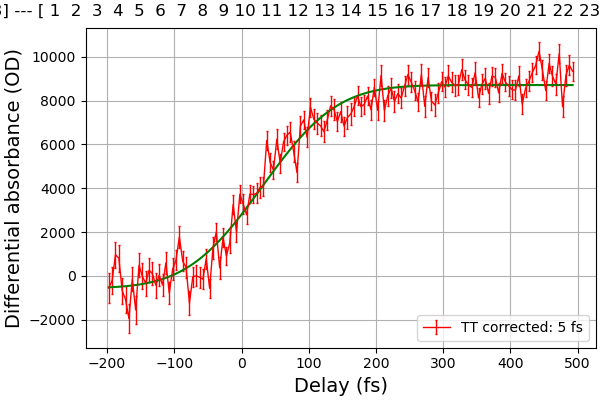

In [30]:
fitflag = True

fig, ax = plt.subplots(constrained_layout=True, figsize=(6,4))
plt.suptitle(titlestring_stack_loop)

label = 'Rebinned: {} fs'.format(binsize)
if withTT:
    label = 'TT corrected: {} fs'.format(binsize)

plt.errorbar(Delay_fs_TT, pp_TT, err_pp, 
              lw=1,color='red', markersize=0,capsize=1,capthick=1,
                   ecolor='red',elinewidth=1,label=label)198.8819
plt.legend (loc = 'lower right')

if fitflag:
    index = ~(np.isnan(Delay_fs_TT) | np.isnan(pp_TT))
    Delay_fs_TT = Delay_fs_TT[index]
    pp_TT=  pp_TT[index]
    err_pp = err_pp[index]
    
    fit = Fit(errfunc_fwhm, estimate_errfunc_parameters)
    # fit = Fit(conv_exp_gauss_heaviside, estimate_conv_exp_gauss_heaviside_parameters)
    fit.estimate(Delay_fs_TT, pp_TT)            # this sets some internal params 
    fit.p0 = better_p0(fit.p0, 0,0)

    #p0 = [0, 100, 0, 200, 0]
    #popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
    #pp_fit = model_decay_1exp(Delay_fs_TT, *popt)
    #t0_fs = popt[0]
    #width_fs = popt[1]
    
    #fit.p0 = better_p0(fit.p0, 3, 50) # overwrite some values (index) if needed: 
    fit.fit(Delay_fs_TT,pp_TT)                  # calculate the fit
    pp_fit = fit.eval(Delay_fs_TT)           # evaluate the curve for plotting
    t0_fs = fit.popt[0]
    width_fs = fit.popt[2]
    plt.plot(Delay_fs_TT, pp_fit, color='green')
    print("Width = {:.4f} fs".format(abs(width_fs*2.355)))
    print("t0 = {:.4f} fs".format(t0_fs))
plt.grid()
plt.ylabel('Differential absorbance (OD)', fontsize=14)
plt.xlabel('Delay (fs)', fontsize=14)
plt.show()

#plt.savefig('/sf/alvra/data/p22285/work/Data_FePhen_p21992/XANES_oscill.png', )

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)
plt.suptitle('run {}'.format(runlist) + ' -- Chunksize={} -- Bin={} fs'.format(chuncksize, binsize))

ax1.plot(t0_fit, label='Fit')
ax1.plot(t0_der, label='Gauss der')
ax1.plot(t0_voigt, label='Voigt')
ax1.set_ylabel('width (fs)')
ax1.set_xlabel('chunk number')
ax1.legend(loc='best')
ax1.set_ylim(-100,100)
ax1.grid()
ax2.hist(t0_der, bins=100)
ax2.hist(t0_voigt, bins=100)
#ax2.set_xlim(0,1000)
ax2.grid()

# Fit decay constants

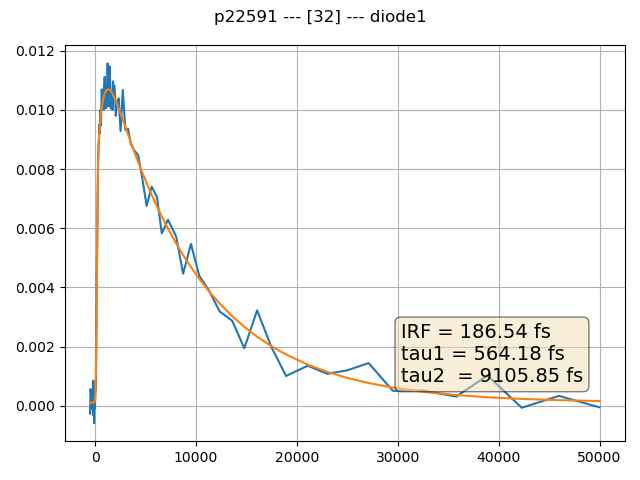

In [132]:
###################### 1 exp #################################
###   x0, sigma, amp1, tau1, C
p0 = [0,  100,   1,    1000, 1]
popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)#198.8819
y_fit = model_decay_1exp(Delay_fs_TT, *popt)

###################### 2 exp #################################
###   x0, sigma, amp1, tau1, C, amp2, tau2
p0 = [200,  200,   1000, 100,  1, 10,   100]
popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(Delay_fs_TT, *popt)

###############################################################
fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack1)))
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, y_fit)

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.15, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

#os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

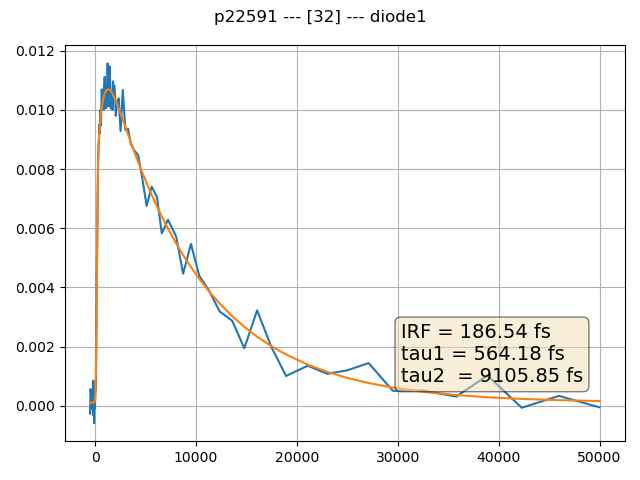

In [132]:
###################### 1 exp #################################
###   x0, sigma, amp1, tau1, C
p0 = [0,  100,   1,    1000, 1]
popt,_  = curve_fit(model_decay_1exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)#198.8819
y_fit = model_decay_1exp(Delay_fs_TT, *popt)

###################### 2 exp #################################
###   x0, sigma, amp1, tau1, C, amp2, tau2
p0 = [200,  200,   1000, 100,  1, 10,   100]
popt,_  = curve_fit(model_decay_2exp, Delay_fs_TT, pp_TT, p0=p0, maxfev=40000)
y_fit = model_decay_2exp(Delay_fs_TT, *popt)

###############################################################
fig, ax = plt.subplots(constrained_layout=True)
plt.suptitle("\n".join(wrap(titlestring_stack1)))
plt.plot(Delay_fs_TT, pp_TT)
plt.plot(Delay_fs_TT, y_fit)

popt = np.pad(popt, (0, 7-len(popt)), 'constant', constant_values=np.nan)
boxstyle = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
boxtext = '\n'.join((r'IRF = {:.2f} fs'.format(np.abs(popt[1]*2.3548)),
                     r'tau1 = {:.2f} fs'.format(np.abs(popt[3])),
                     r'tau2  = {:.2f} fs'.format(np.abs(popt[6]))))
plt.text(0.6, 0.15, boxtext, transform=ax.transAxes, bbox=boxstyle, fontsize=14)

plt.grid()
plt.tight_layout()
#plt.ylim(-0.25, 2)
plt.show()

#os.makedirs(savedir, exist_ok=True)
#plt.savefig(savedir + '/{}.png'.format(ROI.split(':')[-1]))

In [63]:
popt[2]

np.float64(-0.004841981350288851)

In [64]:
popt[5]

np.float64(0.012725962519179472)

In [138]:
import numpy as np
from scipy import special as _special
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
import os
import pandas as pd

In [139]:

def convolved_exp(t, t0, tau, w):
    t = np.asarray(t)
    tau = np.maximum(tau, 1e-3)  
    w   = np.maximum(w, 1e-3)    

    arg1 = (w**2 - 2*tau*(t - t0)) / (2*tau**2)
    arg2 = (w**2 - tau*(t - t0)) / (np.sqrt(2)*w*tau)

    # Avoid overflow
    arg1 = np.clip(arg1, -700, 700)  
    arg2 = np.clip(arg2, -1e2, 1e2)  

    res = 0.5 * np.exp(arg1) * (1 - _special.erf(arg2))
    res = np.nan_to_num(res, nan=0.0, posinf=0.0, neginf=0.0)  # Change NaN or inf to 0
    return res
def model_1d(x, t, numExp, t0_choice='No'):
    t = np.asarray(t)
    F = np.zeros_like(t, dtype=float)
    if t0_choice == 'No':
        w = x[0]
        t0 = x[1]
        taus = x[2:2+numExp]
        As = x[2+numExp:2+numExp+numExp]
        for n in range(numExp):
            F += As[n] * convolved_exp(t, t0, taus[n], w)
    elif t0_choice == 'Fix0':
        w = x[0]
        taus = x[1:1+numExp]
        As = x[1+numExp:1+numExp+numExp]
        t0 = 0.0
        for n in range(numExp):
            F += As[n] * convolved_exp(t, t0, taus[n], w)
    else:
        raise ValueError("t0_choice debe ser 'No' o 'Fix0'")
    return F

def residuals_1d(x, t, y, numExp, t0_choice='No'):
    return model_1d(x, t, numExp, t0_choice) - y

def fit_1d(t, y, numExp=3, t0_choice='No', ini=None, bounds=None, verbose=1):
    if ini is None:
        if t0_choice == 'No':
            w0 = 0.2 * (t.max() - t.min()) if (t.max() - t.min())>0 else 0.1
            t0_0 = 0.0
            taus0 = np.array([0.5 * (3**n) for n in range(numExp)])
            As0 = np.array([(np.max(y)-np.min(y))/numExp * (0.5 if n%2==0 else 1.0) for n in range(numExp)])
            ini = np.concatenate(([w0, t0_0], taus0, As0))
        else:
            w0 = 0.2 * (t.max() - t.min()) if (t.max() - t.min())>0 else 0.1
            taus0 = np.array([0.5 * (3**n) for n in range(numExp)])
            As0 = np.array([(np.max(y)-np.min(y))/numExp * (0.5 if n%2==0 else 1.0) for n in range(numExp)])
            ini = np.concatenate(([w0], taus0, As0))

    if bounds is None:
        if t0_choice == 'No':
            lower = np.concatenate(([1e-6, t.min()-abs(t.min())*10], np.full(numExp, 1e-6), np.full(numExp, -np.inf)))
            upper = np.concatenate(([ (t.max()-t.min())*10 if (t.max()-t.min())>0 else 10, t.max()+abs(t.max())*10], np.full(numExp, 1e12), np.full(numExp, np.inf)))
        else:
            lower = np.concatenate(([1e-6], np.full(numExp, 1e-6), np.full(numExp, -np.inf)))
            upper = np.concatenate(([ (t.max()-t.min())*10 if (t.max()-t.min())>0 else 10], np.full(numExp, 1e12), np.full(numExp, np.inf)))
        bounds = (lower, upper)

    res = least_squares(residuals_1d, ini, args=(t, y, numExp, t0_choice), bounds=bounds, verbose=verbose, jac='2-point')

    J = res.jac
    try:
        cov = np.linalg.inv(J.T @ J)
        dof = max(1, (len(y) - len(res.x)))
        s_sq = np.sum(res.fun**2) / dof
        cov = cov * s_sq
    except np.linalg.LinAlgError:
        cov = np.zeros((len(res.x), len(res.x)))
    return res, res.x, cov


In [148]:
# Fit to 3 exponential model
numExp = 3
t0_choice = 'No'    
ini = np.array([
    0.5,      # w
    0.0,      # t0
    0.14, 0.39, 8.5,   # taus (3)
    -.001, -0.003, 0.01    # Amps (3)
])

lower = (
    [1e-6, -5.0] +      # w, t0
    [1e-6]*3 +          # tau1..tau3
    [-np.inf]*3         # A1..A3
)

upper = (
    [10.0, np.max(Delay_fs_TT)] +  # w, t0
    [1e6]*3 +            # tau1..tau3
    [np.inf]*3           # A1..A3
)

bounds = (lower, upper)

`ftol` termination condition is satisfied.
Function evaluations 80, initial cost 2.9469e-03, final cost 1.0547e-05, first-order optimality 7.80e-05.

=== Resultados ajustados ===
w  = 0.5000 ± 924829.1157
t0 = 8.5596 ± 7235965.3191
tau1 = 3.2444 ± 150168.3608
A1   = 0.051595 ± 113278.378253
tau2 = 234.7704 ± 16.1507
A2   = -0.014470 ± 445.931569
tau3 = 10127.6806 ± 330.5764
A3   = 0.012259 ± 8.758442


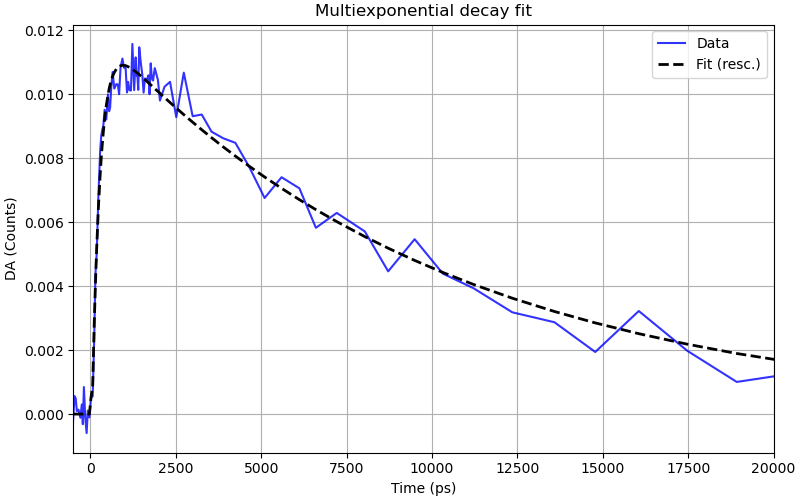

In [149]:
res, xopt, cov = fit_1d(Delay_fs_TT, pp_TT, numExp=numExp, t0_choice=t0_choice, ini=ini, bounds=bounds, verbose=1)

#  Parameters
w_opt = xopt[0]
t0_opt = xopt[1]
taus_opt = xopt[2:2+numExp]
As_opt = xopt[2+numExp:2+numExp+numExp]
errs = np.sqrt(np.abs(np.diag(cov))) if cov.size else np.zeros_like(xopt)

print("\n=== Resultados ajustados ===")
print(f"w  = {w_opt:.4f} ± {errs[0]:.4f}")
print(f"t0 = {t0_opt:.4f} ± {errs[1]:.4f}")
for n in range(numExp):
    print(f"tau{n+1} = {taus_opt[n]:.4f} ± {errs[2+n]:.4f}")
    print(f"A{n+1}   = {As_opt[n]:.6f} ± {errs[2+numExp+n]:.6f}")

# Model fit
y_fit_norm = model_1d(xopt, Delay_fs_TT, numExp=numExp, t0_choice=t0_choice)
y_fit = y_fit_norm

# Plots
plt.figure(figsize=(8,5),constrained_layout=True)
plt.plot(Delay_fs_TT, pp_TT, 'b', label='Data', alpha=0.8)
plt.plot(Delay_fs_TT, y_fit, 'k--', lw=2, label='Fit (resc.)')
plt.xlabel('Time (ps)')
plt.ylabel('DA (Counts)')
plt.title('Multiexponential decay fit')
plt.xlim(-500, 20000)
plt.legend()
plt.grid(True)
plt.show()

## Overlay data

In [299]:
pgroup = 'p22591'

runlist2load = [67, 73, 74]
Loaddir_folder ='_singlerun'# '_single'
whichdiode = 'diode2'  #both_diodes

##############################################
Loaddir = '/sf/alvra/data/{}/work/Reduced_data/{}/'.format(pgroup, Loaddir_folder)

titlestring_stack = pgroup + ' --- ' +str(runlist2load)
print ('Will load {} runs: {} from {}'.format(len(runlist2load), runlist2load, Loaddir))
check = []
for run in runlist2load:
    try:
        check.append(glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[0])
    except:
        print("Some runs are missing")
check

Will load 3 runs: [67, 73, 74] from /sf/alvra/data/p22591/work/Reduced_data/_singlerun/


['/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run67/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run73/run_array_diode2.npy',
 '/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run74/run_array_diode2.npy']

/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run67/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run73/run_array_diode2.npy
/sf/alvra/data/p22591/work/Reduced_data/_singlerun/run74/run_array_diode2.npy


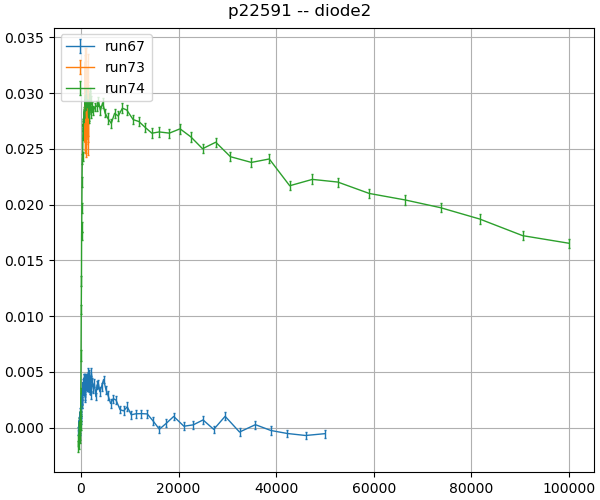

In [301]:
#fig, ((ax1, ax3)) = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)
fig, ((ax1)) = plt.subplots(1, figsize=(6, 5), constrained_layout=True)
if whichdiode=='diode2':
    switchdiode=False
else:
    switchdiode=True
scale = [1]*len(runlist2load)
shift = [0]*len(runlist2load)
for index, run in enumerate(runlist2load):
    filepath = glob.glob(Loaddir + '/*{}*/*run_array*{}*'.format(run, whichdiode))[0]
    print (filepath)
    run_array = np.load(filepath, allow_pickle=True).item()
    for key in run_array.keys():
        runname  = run_array[key]["name"].split('-')[0]
        GS       = run_array[key]["GS"]
        err_GS   = run_array[key]["err_GS"]
        ES       = run_array[key]["ES"]
        err_ES   = run_array[key]["err_ES"]
        pp_rebin = run_array[key]["pp"]
        err_pp   = run_array[key]["err_pp"]
        rbk      = run_array[key]["readbacks"]
        
    # ax1.errorbar(rbk, GS, err_GS, lw=1,markersize=0,capsize=1,capthick=1,
    #                elinewidth=1,label=runname)#+' '+str(lab[index]))
    # ax1.errorbar(rbk, ES, err_ES, lw=1,markersize=0,capsize=1,capthick=1,
    #               elinewidth=1,label=runname)#+' '+str(lab[index]))
    ax1.errorbar(rbk+shift[index], pp_rebin*scale[index], err_pp, lw=1,markersize=0,capsize=1,capthick=1,
                   elinewidth=1,label=runname)#+' '+str(lab[index]))
    
plt.suptitle('{} -- {}'.format(pgroup, whichdiode))
ax1.legend(loc = 'upper left')
ax1.grid()
# ax3.legend(loc = 'upper left')
# ax3.grid()